In [1]:
import json
import os
import itertools
import pandas as pd
import numpy as np
import re
from datetime import datetime as dt

import sys
sys.path.append(".\\sample")
from SALibRepastParams import num_levels, params, random_seed, init_problem, calc_second_order, policies

import batch_data_utils as bd_utils

In [2]:
with open(".//config.json") as f:
    config = json.load(f)

In [3]:
file_datetime_string = config['file_datetime_string']
vehicle_density_timestamp = config['vehicle_density_timestamp']
setting = config['setting']

gis_data_dir = os.path.abspath("..\\data\\model_gis_data")
data_dir = config['batch_data_dir']
img_dir = "..\\output\\img\\"

In [4]:
output_paths = bd_utils.get_ouput_paths(file_datetime_string, vehicle_density_timestamp, data_dir)
output_sd_data = output_paths["output_sd_data"]

## Get data to analyse

In [40]:
dfDD = pd.read_csv(output_sd_data)

# get policy parameter and split the data into groups for different policies
policy_param = list(policies.keys())[0]
policy_values = policies[policy_param]
scenario_param_cols =  [i for i in params if i!=policy_param]

# Now group by scenario and aggregate to find difference in outputs between policy conditions
for c in scenario_param_cols:
	dfDD[c] = dfDD[c].astype(str) # Helps with grouping, makes matching doubles easier

dfPolicyDiff = dfDD.groupby(scenario_param_cols).agg( 	PedDistDiff = pd.NamedAgg(column = "DistPAPed", aggfunc=lambda s: s.values[0] - s.values[1]),
														VehDistDiff = pd.NamedAgg(column = "DistPAVeh", aggfunc=lambda s: s.values[0] - s.values[1]),
														PedDurDiff = pd.NamedAgg(column = "DurPAPed", aggfunc=lambda s: s.values[0] - s.values[1]),
														VehDurDiff = pd.NamedAgg(column = "DurPAVeh", aggfunc=lambda s: s.values[0] - s.values[1]),
														CrossEntDiff = pd.NamedAgg(column = "cross_entropy", aggfunc=lambda s: s.values[0] - s.values[1]),
														PedDistDiffFrac = pd.NamedAgg(column = "DistPAPed", aggfunc=lambda s: (s.values[0] - s.values[1]) / s.values[0]),
														CrossEntDiffFrac = pd.NamedAgg(column = "cross_entropy", aggfunc=lambda s: (s.values[0] - s.values[1]) / s.values[0]),
														CountRuns = pd.NamedAgg(column = "run", aggfunc=lambda s: s.shape[0]),
														RunsStr = pd.NamedAgg(column = "run", aggfunc=lambda s: ":".join(str(i) for i in s.tolist())),
													).reset_index()

for c in scenario_param_cols:
	dfPolicyDiff[c] = dfPolicyDiff[c].astype(float)

# Check that there are expected number of runs per scenario
assert (dfPolicyDiff['CountRuns']==2).all()

# Identify successfull scenarios, categorise into two groups
dfPolicyDiff['success'] = (dfPolicyDiff['PedDistDiffFrac'] > -0.1) & (dfPolicyDiff['CrossEntDiffFrac']<0) # crossing is more ordered and pedestrian trips not made too much longer on average
dfPolicyDiff['ent_decreased'] = dfPolicyDiff['CrossEntDiffFrac']<0 

print(dfPolicyDiff['success'].value_counts())
print(dfPolicyDiff['ent_decreased'].value_counts())

False    183
True      17
Name: success, dtype: int64
False    183
True      17
Name: ent_decreased, dtype: int64


## Analyse using tools in ema workbench

In [22]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import prim
import seaborn as sns

assert config['setting'] == 'latin' # expect LH desig to be used when doing SD

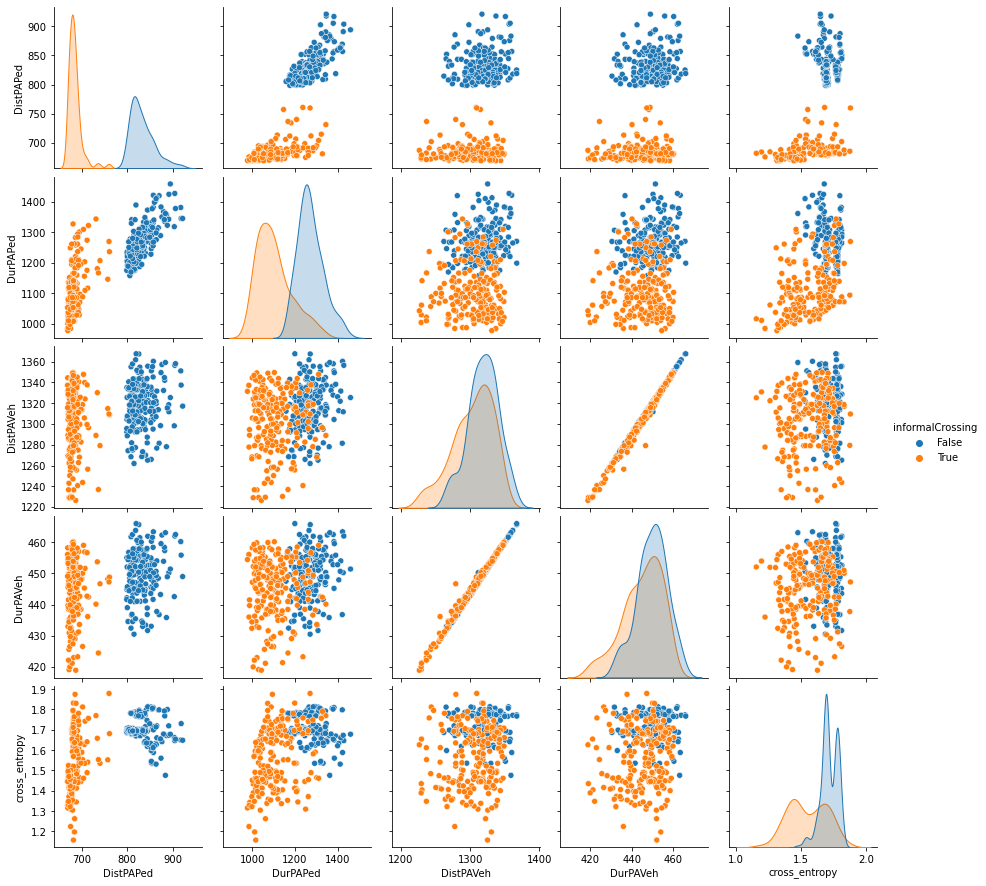

In [23]:
#
# Initial exploratory analysis of multiple outcomes
#

experiments = dfDD.loc[:, params]

outcome_vars = ['DistPAPed','DurPAPed', 'DistPAVeh', 'DurPAVeh', 'cross_entropy']
outcomes = {k:dfDD[k].values for k in outcome_vars}

# Create pairs plot
data = dfDD.loc[:, outcome_vars]
data['informalCrossing'] = experiments['informalCrossing']
sns.pairplot(data, hue='informalCrossing', vars=outcome_vars)

In [41]:
#
# PRIM analysis requires a boolean outcome variable
#
# select parameters that actually varied
varied_scenario_param_cols = [i for i in scenario_param_cols if params[i]['type']=='list']

# Now use PRIM to identify what determines policy success/failure most
x = dfPolicyDiff.loc[:, varied_scenario_param_cols].copy()
y = dfPolicyDiff['ent_decreased'].values

# Round values to make visualisations clearer
for c in ['epsilon','lambda','alpha', 'tacticalPlanHorizon']:
	x[c] = x[c].map(lambda x: np.round(x, 4))
    
prim_alg = prim.Prim(x, y, threshold=0.5)
box1 = prim_alg.find_box()

In [42]:
dfPolicyDiff['success'].value_counts()

False    183
True      17
Name: success, dtype: int64

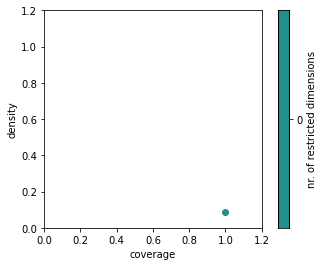

In [43]:
box1.show_tradeoff()
plt.show()

In [44]:
box1.inspect()

coverage      1.0
density     0.085
id              0
mass          1.0
mean        0.085
res_dim         0
Name: 0, dtype: object

Empty DataFrame
Columns: [(box 0, min), (box 0, max), (box 0, qp values)]
Index: []



C:\Anaconda3\envs\geoforge\lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:442: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.set_ylim(top=-0.5, bottom=nr_unc - 0.5)


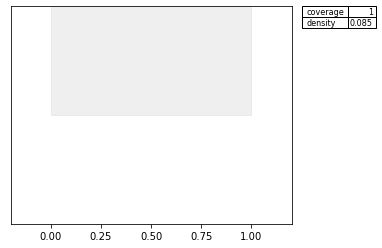

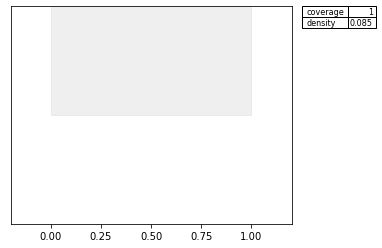

In [45]:
box1.inspect(style='graph')

In [35]:
box1.show_pairs_scatter()

ValueError: No variables found for grid columns.

In [36]:
box2 = prim_alg.find_box()

In [37]:
box2.show_pairs_scatter()

AttributeError: 'NoneType' object has no attribute 'show_pairs_scatter'

#### Repeat PRIM analysis with a different metric pof policy success